## Exoplanet M-R Relationship

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# load the CSV file into a structured array
exoplanet_sample = np.genfromtxt('PSCompPars_2023.03.30_10.09.33.csv', delimiter=',', names=True, dtype=None, 
                                 encoding = 'utf-8', invalid_raise = False)
exoplanet_sample.dtype  # for now just to remember names of columns

<ipython-input-2-85334fa6a7a7>:2: ConversionWarning: Some errors were detected !
    Line #4841 (got 47 columns instead of 84)
  exoplanet_sample = np.genfromtxt('PSCompPars_2023.03.30_10.09.33.csv', delimiter=',', names=True, dtype=None,


dtype([('pl_name', '<U29'), ('hostname', '<U27'), ('sy_snum', '<i4'), ('sy_pnum', '<i4'), ('discoverymethod', '<U29'), ('disc_year', '<i4'), ('disc_facility', '<U46'), ('pl_controv_flag', '<i4'), ('pl_orbper', '<f8'), ('pl_orbpererr1', '<f8'), ('pl_orbpererr2', '<f8'), ('pl_orbperlim', '<i4'), ('pl_orbsmax', '<f8'), ('pl_orbsmaxerr1', '<f8'), ('pl_orbsmaxerr2', '<f8'), ('pl_orbsmaxlim', '<i4'), ('pl_rade', '<f8'), ('pl_radeerr1', '<f8'), ('pl_radeerr2', '<f8'), ('pl_radelim', '<i4'), ('pl_radj', '<f8'), ('pl_radjerr1', '<f8'), ('pl_radjerr2', '<f8'), ('pl_radjlim', '<i4'), ('pl_bmasse', '<f8'), ('pl_bmasseerr1', '<f8'), ('pl_bmasseerr2', '<f8'), ('pl_bmasselim', '<i4'), ('pl_bmassj', '<f8'), ('pl_bmassjerr1', '<f8'), ('pl_bmassjerr2', '<f8'), ('pl_bmassjlim', '<i4'), ('pl_bmassprov', '<U16'), ('pl_orbeccen', '<f8'), ('pl_orbeccenerr1', '<f8'), ('pl_orbeccenerr2', '<f8'), ('pl_orbeccenlim', '<i4'), ('pl_insol', '<f8'), ('pl_insolerr1', '<f8'), ('pl_insolerr2', '<f8'), ('pl_insollim', '<

In [3]:
# importing data using pandas instead because of error above
exoplanet_sample = pd.read_csv('PSCompPars_2023.03.30_10.09.33.csv', delimiter=',', header = 0, encoding='utf-8')

# print the names of the fields in the array
#print(exoplanet_sample.dtypes)

## Cutting Data

In [4]:
# cutting out non main sequence stars
for i in exoplanet_sample['st_spectype']:
    if np.logical_and(np.logical_and('M' not in i, 'F' not in i), np.logical_and('G' not in i, 'K' not in i)):
        exoplanet_sample.drop(exoplanet_sample.index[(exoplanet_sample["st_spectype"] == i)], axis=0, inplace = True)

exoplanet_sample['st_spectype']

0       G8 III
1       K4 III
2       K0 III
3         K0 V
4         G3 V
         ...  
5307      F8 V
5308      F8 V
5309      F8 V
5310    G9 III
5311    G9 III
Name: st_spectype, Length: 1847, dtype: object

In [5]:
# obtaining transiting planets from Kepler, K2, and TESS missions
exoplanet_sample = exoplanet_sample[exoplanet_sample['discoverymethod'] == 'Transit']

exoplanet_sample = exoplanet_sample[np.logical_or(np.logical_or(exoplanet_sample['disc_facility'] == 'K2', exoplanet_sample['disc_facility'] == 'Transiting Exoplanet Survey Satellite (TESS)'),
                                                   exoplanet_sample['disc_facility'] == 'Kepler')]

# cutting out binary systems
exoplanet_sample = exoplanet_sample[exoplanet_sample['sy_snum'] == 1.0]

#MR_relationship = exoplanet_sample[exoplanet_sample['pl_bmassprov'] == 'M-R relationship']

# cutting out planets whose masses were determined by MR relationship (that's what were trying to show)
# don't want these to bias our fits
exoplanet_sample = exoplanet_sample[exoplanet_sample['pl_bmassprov'] != 'M-R relationship']

# cutting out planets whose masses were not determined by radial velocity methods?
#exoplanet_sample = exoplanet_sample[exoplanet_sample['ttv_flag'] != 1]

exoplanet_sample = exoplanet_sample[exoplanet_sample['st_rad'] != 0.0]
                                              
# applying limits on planet radii and mass
exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_rade'] < 8.0,
                                                   exoplanet_sample['pl_rade'] > 0.0)]

exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_bmasse'] > 0.0, 
                                                   exoplanet_sample['pl_bmasse'] < 70.0)]

# cutting out all exoplanets that don't have error bars on radius/mass measurements
exoplanet_sample = exoplanet_sample[exoplanet_sample['st_masserr1'] != 0.0]
exoplanet_sample = exoplanet_sample[exoplanet_sample['st_masserr2'] != 0.0]

exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_radeerr1'] != 0.0, 
                                                   abs(exoplanet_sample['pl_radeerr1']) < .10*abs(exoplanet_sample['pl_rade']))]
exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_radeerr2'] != 0.0, 
                                                   abs(exoplanet_sample['pl_radeerr2']) < .10*abs(exoplanet_sample['pl_rade']))]

exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_bmasseerr1'] != 0.0, 
                                                   abs(exoplanet_sample['pl_bmasseerr1']) < .20*abs(exoplanet_sample['pl_bmasse']))]
exoplanet_sample = exoplanet_sample[np.logical_and(exoplanet_sample['pl_bmasseerr2'] != 0.0, 
                                                   abs(exoplanet_sample['pl_bmasseerr2']) < .20*abs(exoplanet_sample['pl_bmasse']))]

In [7]:
len(exoplanet_sample)

97

## Sorting out planet M-R data and stellar M-R data then taking the log.

In [12]:
# planet MR and stellar MR data
Mp = exoplanet_sample['pl_bmasse']
Mp_errup = abs(exoplanet_sample['pl_bmasseerr1'])
Mp_errlow = abs(exoplanet_sample['pl_bmasseerr2'])

Mplog = np.log(Mp)
Mp_erruplog = Mp_errup / Mp
Mp_errlowlog = Mp_errlow / Mp

Rp = exoplanet_sample['pl_rade']
Rplog = np.log(Rp)

Rp_errup = abs(exoplanet_sample['pl_radeerr1'])
Rp_errlow = abs(exoplanet_sample['pl_radeerr2'])
Rp_erruplog = Rp_errup / Rp
Rp_errlowlog = Rp_errlow / Rp

Rs = exoplanet_sample['st_rad']
Rslog = np.log(Rs)

Rs_errup = abs(exoplanet_sample['st_raderr1'])
Rs_errlow = abs(exoplanet_sample['st_raderr2'])
Rs_erruplog = Rs_errup / Rs
Rs_errlowlog = Rs_errlow / Rs

Ms = exoplanet_sample['st_mass']
Mslog = np.log(Ms)

Ms_errup = abs(exoplanet_sample['st_masserr1'])
Ms_errlow = abs(exoplanet_sample['st_masserr2'])
Ms_erruplog = Ms_errup / Ms
Ms_errlowlog = Ms_errlow / Ms

## Plotting M-R Data

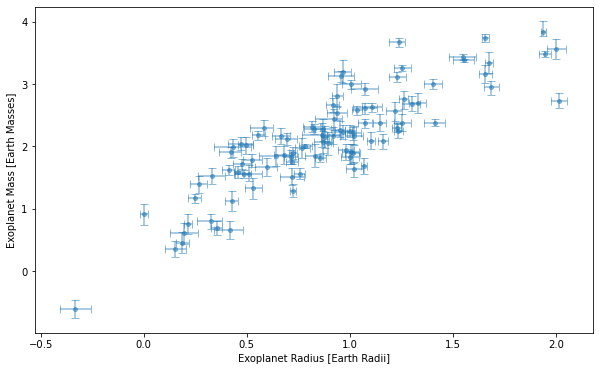

In [10]:
plt.figure(figsize = (10,6))
plt.errorbar(Rplog, Mplog, xerr = (Rp_erruplog, Rp_errlowlog), yerr = (Mp_erruplog, Mp_errlowlog),
             linestyle = 'None',capsize=4, marker ='.', alpha = 0.5, ms=8)

plt.ylabel('Exoplanet Mass [Earth Masses]')
plt.xlabel('Exoplanet Radius [Earth Radii]')
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([1e-1,1e2])
#plt.xlim([1e-1+0.5,1e1])
#plt.legend()
plt.show()

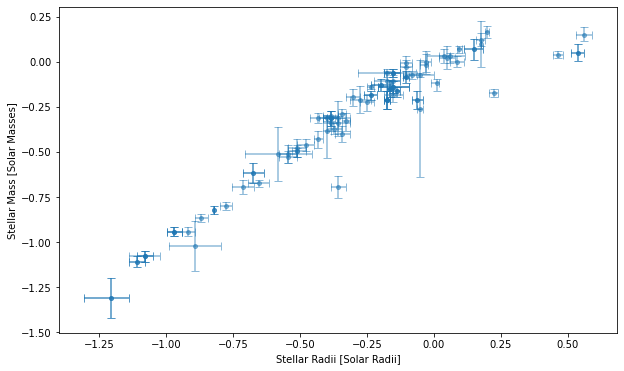

In [13]:
plt.figure(figsize = (10,6))
plt.errorbar(Rslog, Mslog, xerr = (Rs_erruplog, Rs_errlowlog), yerr = (Ms_erruplog, Ms_errlowlog),
             linestyle = 'None',capsize=4, marker ='.', alpha = 0.5, ms=8)

plt.xlabel('Stellar Radii [Solar Radii]')
plt.ylabel('Stellar Mass [Solar Masses]')
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([0,8.0])
#plt.xlim([0,2.0])
#plt.legend()
plt.show()

## MCMC fitting

In [14]:
import emcee
import corner

To fit our data, we use the emcee module to perform an MCMC to determine two parameters of a linear model $y = ax+b$ to the M-R relationships for exoplanets and stars. Taken from coding lab 7, by assuming gaussian error bars, we can take a gaussian distribution as our likelihood. Since we have error bars for both $y$ and $x$, we need to use a multivariate gaussian distribution. However, we can assume that the covariance between $x$ and $y$ is zero since the method of determining the planet's radius and the method of determining the planet's mass is independent of each other. Also assuming a uniform prior, we can then study the posteriors of $a$ and $b$.

In [21]:
def log_prior(theta):
    a, b = theta
    if -1.0 < a < 3. and -5. < b < 5.:
        return 0.0 # the constant doesn't matter since MCMCs only care about *ratios* of probabilities
    return -np.inf # log(0) = -inf

def log_likelihood(theta, x, y, xerr, yerr):
    a, b = theta
    model = a * x + b
    sigmay = yerr ** 2
    sigmax = xerr **2
    #term1 = (y - model) ** 2 / sigma2 + np.log(sigma2)
    return -0.5 * np.sum((y - model) ** 2 / sigmay + (x - np.mean(x)) ** 2 / sigmax + np.log(np.sqrt(sigmay*sigmax))) # the 2pi factor doesn't affect the shape

def log_post(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

In [23]:
num_iter = 2000
ndim = 2 # number of parameters
nwalkers = 200
initial_pos = np.array((0.5, 0.0)) + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=(Rplog, Mplog, Rp_erruplog, Mp_erruplog))
sampler.run_mcmc(initial_pos, num_iter, progress=True);

100%|██████████| 2000/2000 [12:05<00:00,  2.76it/s]


In [24]:
samples = sampler.get_chain()

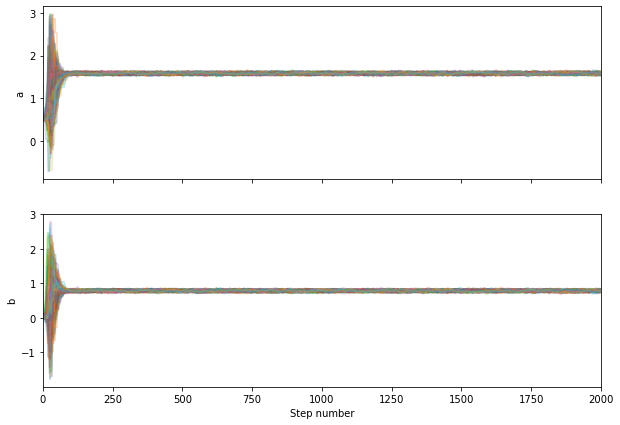

In [25]:
f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

By inspection we deicided to discard the first 100 interations to eliminate the burn-in phase.

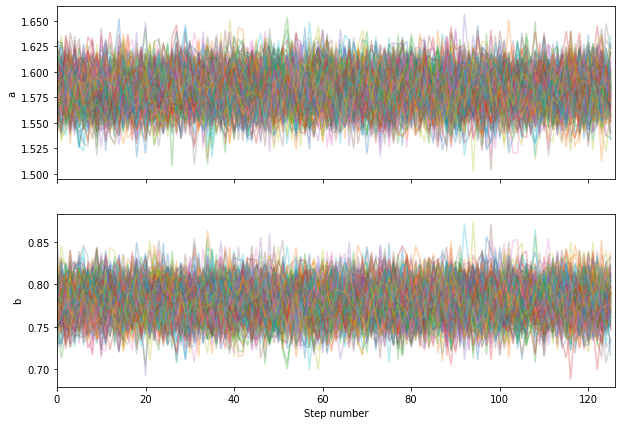

In [26]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat = True)

samples = sampler.get_chain(discard=100, thin = 15)
f, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ["a", "b"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :,i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number");

To visualize our posteriors for $a$ and $b$, we can use corner. We've marked the median and the 16th/84th percentiles so that you can see what the 68% credibility region looks like for each parameter:

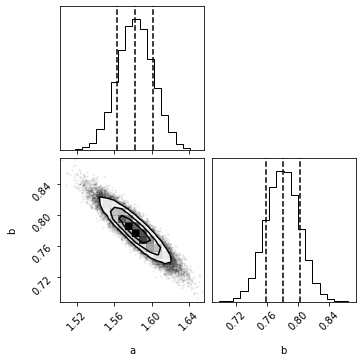

In [27]:
fig = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84]);

Now we can plot representative fits for our M-R relationships

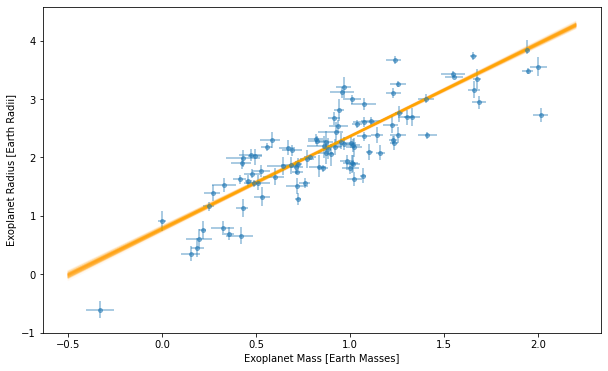

In [34]:
inds = np.random.randint(len(flat_samples), size=100)
x0 = np.linspace(-0.5, 2.2, 13)
f, ax = plt.subplots(figsize=(10,6))
for ind in inds:
    sample = flat_samples[ind]
    ax.plot(x0, sample[0] * x0 + sample[1], alpha=0.05, color='orange')
#ax.errorbar(Rplog, Mplog, yerr=Mp_erruplog, linestyle = 'None', marker ='.', color='black', ms=8)
ax.errorbar(Rplog, Mplog, xerr = (Rp_erruplog, Rp_errlowlog), yerr = (Mp_erruplog, Mp_errlowlog),
             linestyle = 'None', marker ='.', alpha = 0.5, ms=8)
#ax.set_xlim(0, 10.)
ax.set_xlabel('Exoplanet Mass [Earth Masses]')
ax.set_ylabel('Exoplanet Radius [Earth Radii]')
plt.show()

Calculating fluxes

In [35]:
Re = 6371  # km
Rs = 696340  # km

Ms = 1.989e30  # kg

rat = Re/Rs

Kepler = exoplanet_sample[exoplanet_sample['disc_facility'] == 'Kepler']
K2 = exoplanet_sample[exoplanet_sample['disc_facility'] == 'K2']
TESS = exoplanet_sample[exoplanet_sample['disc_facility'] == 'Transiting Exoplanet Survey Satellite (TESS)']

#hostnames = set(Kepler['hostname'])

# planets for KOI
KOI = Kepler[Kepler['hostname'] == 'KOI-142']

Mh = KOI['st_rad']
#print(KOI['pl_rade'])
#print(KOI['st_rad'])

#print( 0.5 / Mh * rat)  # unit of Re/Rsolar

#print(KOI['st_mass']*Ms)

lum = (KOI['st_mass'])**3.5  # units of solar luminosity

dist = KOI['sy_dist']  # in pc

dist_sun = 4.8642e-6  # in pc

f_sun = 1373  # W/m2

dist2_rat = (dist_sun)**2/(dist)**2

m_sun = -26.74

f_star = lum*dist2_rat  # in Fs/Fsolar

orbitalperiod = KOI['pl_orbper']
semimajoraxis = KOI['pl_orbsmax']
#print(orbitalperiod)
#print(semimajoraxis)

ap_mag = -2.5*np.log10(f_star) + m_sun

#ap_mag * 0.98

ap_mag_p = -2.5*np.log10(0.98) + ap_mag

ap_mag_p
# #f_star

1850    12.765987
dtype: float64